In [6]:
from init import *
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from easydl import clear_output
from models_.unet_model1 import UNet
from lossers import dice_loss
from torch import optim
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F

[easydl] tensorflow not available!


In [2]:
epochs=200
device = 'cuda:7'
cfg0['data']['path']=r'/home/wanghaifeng/project_work/datasets/changedetection_dataset/zaihai/imgs8'
cfg0['training']['batch_size']=4
model = UNet(3,3)
n_claess,train_loader, val_loder = get_dataloader(cfg0)
optimizer, scheduler = get_optimizer_scheduler(model)
model = model.to(device).train()#.half()

In [8]:
    learning_rate: float = 1e-5
    amp = False
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.MultiLabelSoftMarginLoss()


    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0
        with tqdm(total=100, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            losss=[]
            for images in train_loader:
                t2 = images['t2'].to(device)  # .half()
                mask1 = images['mask2'].to(device,dtype=torch.long)#.half()
                
                
                with torch.cuda.amp.autocast(enabled=amp):
                    r1 = model(t2)
                    loss = criterion(r1,mask1)\
                           + dice_loss(F.softmax(r1, dim=1).float(),
                                       F.one_hot(mask1.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                                       multiclass=True)\

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()
                losss.append(loss.item())
                pbar.update(t2.shape[0])
                pbar.set_postfix(**{'loss (batch)': loss.item()})
            pbar.set_postfix(**{'loss (epoch)': sum(losss)/len(losss)})  
            
        

Epoch 1/200:  16%|█▌        | 16/100 [00:25<02:14,  1.60s/img, loss (batch)=1.39]


KeyboardInterrupt: 

In [10]:
from glob import glob
import torch
import cv2
import numpy as np
import torch.nn.functional as F
from models_.unet_model1 import UNet
from pathlib import Path

def show_result(r1):
    probs = F.softmax(r1, dim=1)
    img1 = torch.argmax(probs,1)
    img1 = img1[0].detach().cpu().numpy()
    return img1

def test(imgs_path,device,model=None,weights_path='test15.pt',save_path=None,num_limt=1,img_size=(640,640),):
    for img_p in imgs_path[:num_limt]:
        img = cv2.imread(img_p)
        img = cv2.resize(img,img_size)
        
        mask2_p = img_p.replace('t2','mask2')
        if Path(mask2_p).exists():
            mask = cv2.imread(mask2_p)
            mask = cv2.resize(mask,img_size)
            
        img = img.transpose(2,0,1)
        img = np.array([img])
        img = torch.from_numpy(img).to(device)
        img = img/255
        
        if model is None:
            model = torch.load(weights_path,map_location='cpu')
            model = model.to(device).eval()

        with torch.no_grad():
            rs = model(img,show=save_path)
        
        # for i,r in enumerate(rs):
        # img = show_result(rs)
        img=rs
    return img,mask


device = 'cuda:7'
imgs_path = glob(r'/home/wanghaifeng/project_work/datasets/changedetection_dataset/zaihai/imgs8/train/t2/*.png')

model_name = 'model_unet_2022_10_09_10_10_41'



In [24]:
img,mask = test(imgs_path,device,model=None,weights_path='weights/'+model_name+'/model.pt',save_path=None,img_size=(640,640),num_limt=1)

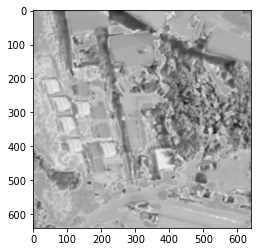

In [29]:
plt.imshow(img1[...,0],'gray')

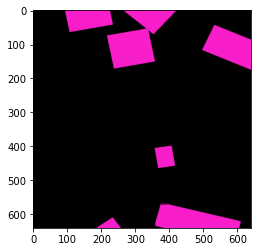

In [29]:
plt.imshow(mask)